# Importing Libraries and Dataset

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv(r"C:\Users\ACER\Downloads\playground-series-s4e6\train.csv", index_col='id')

In [3]:
# Encode the target feature
le = LabelEncoder()
df_train['Target'] = le.fit_transform(df_train['Target'])

In [4]:
df_train.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,2
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,0
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,0
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,1
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,2


# Splitting and Preprocessing

In [5]:
X = df_train.drop(columns = 'Target')
y = df_train['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, test_size = 0.2)

In [6]:
# Pipeline
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

num_feature = ['Previous qualification (grade)',
    'Admission grade',
    'Age at enrollment',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate',
    'Inflation rate',
    'GDP','Application order']

cat_feature = ['Marital status',
    'Application mode',
    'Course','Daytime/evening attendance',
    'Previous qualification','Nacionality',"Mother's qualification","Father's qualification","Mother's occupation",
    "Father's occupation",'Displaced',
    'Educational special needs','Debtor','Tuition fees up to date','Gender','Scholarship holder','International']

preprocessor = ColumnTransformer([
    ('numeric', numerical_pipeline, num_feature),
    ('categoric', categorical_pipeline, cat_feature)
])

# Modelling

In [7]:
pipeline_cb = Pipeline([
    ('prep', preprocessor),
    ('algo', CatBoostClassifier(verbose = 0))
])

In [8]:
pipeline_cb.fit(X_train, y_train)

y_train_pred = pipeline_cb.predict(X_train)
y_test_pred = pipeline_cb.predict(X_test)

y_train_pred = le.inverse_transform(y_train_pred)
y_test_pred = le.inverse_transform(y_test_pred)
y_train_original = le.inverse_transform(y_train)
y_test_original = le.inverse_transform(y_test)

train_f1 = f1_score(y_train_original, y_train_pred, average = 'weighted')
test_f1 = f1_score(y_test_original, y_test_pred, average = 'weighted')

print(f"Training F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")

D:\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training F1 Score: 0.8528335491831845
Test F1 Score: 0.8310450566606753


# Hyperparameter Tuning

In [9]:
param_grid = {
    'algo__iterations': [100, 200],
    'algo__learning_rate': [0.01, 0.1],
    'algo__depth': [4, 6, 8],
    'algo__l2_leaf_reg': [1, 3, 5],
    'algo__border_count': [32, 64, 128]
}

In [10]:
grid_search = GridSearchCV(
    pipeline_cb, param_grid, scoring = make_scorer(f1_score, average = 'weighted'),
    cv = 3, verbose = 2, n_jobs = -1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'algo__border_count': 128, 'algo__depth': 8, 'algo__iterations': 200, 'algo__l2_leaf_reg': 3, 'algo__learning_rate': 0.1}


In [11]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Previous qualification '
                                                   '(grade)',
                                                   'Admission grade',
                                                   'Age at enrollment',
                                                   'Curricular units 1st sem '
                                                   '(credited)',
                                                   'Curricular units 1st sem '
                                                   '(enrolled)',
                                                   'Curricular units 1st sem '
                                                   '(evaluations)',
                                                   'Curricular units 1st sem '
                                                   '(approved)',
                                                   'Curricular units 1st se...
                                                   'Application mode', 'Course',
                                                   'Daytime/evening attendance',
                                                   'Previous qualification',
                                                   'Nacionality',
                                                   "Mother's qualification",
                                                   "Father's qualification",
                                                   "Mother's occupation",
                                                   "Father's occupation",
                                                   'Displaced',
                                                   'Educational special needs',
                                                   'Debtor',
                                                   'Tuition fees up to date',
                                                   'Gender',
                                                   'Scholarship holder',
                                                   'International'])])),
                ('algo',
                 <catboost.core.CatBoostClassifier object at 0x000001A6D529E610>)])

In [12]:
y_train_pred_best = best_model.predict(X_train)
y_test_pred_best = best_model.predict(X_test)

y_train_pred_best = le.inverse_transform(y_train_pred_best)
y_test_pred_best = le.inverse_transform(y_test_pred_best)
y_train_original_best = le.inverse_transform(y_train)
y_test_original_best = le.inverse_transform(y_test)

train_f1_best = f1_score(y_train_original_best, y_train_pred_best, average = 'weighted')
test_f1_best = f1_score(y_test_original_best, y_test_pred_best, average = 'weighted')

print(f"Tuned Training F1 Score: {train_f1_best}")
print(f"Tuned Test F1 Score: {test_f1_best}")

D:\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Tuned Training F1 Score: 0.8406813717854638
Tuned Test F1 Score: 0.82881330555337


# Evaluation

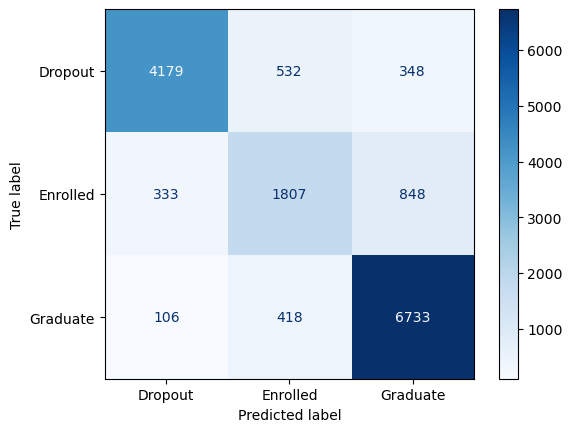

In [13]:
# Confusion matrix for the best model
cm = confusion_matrix(y_test_original_best, y_test_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

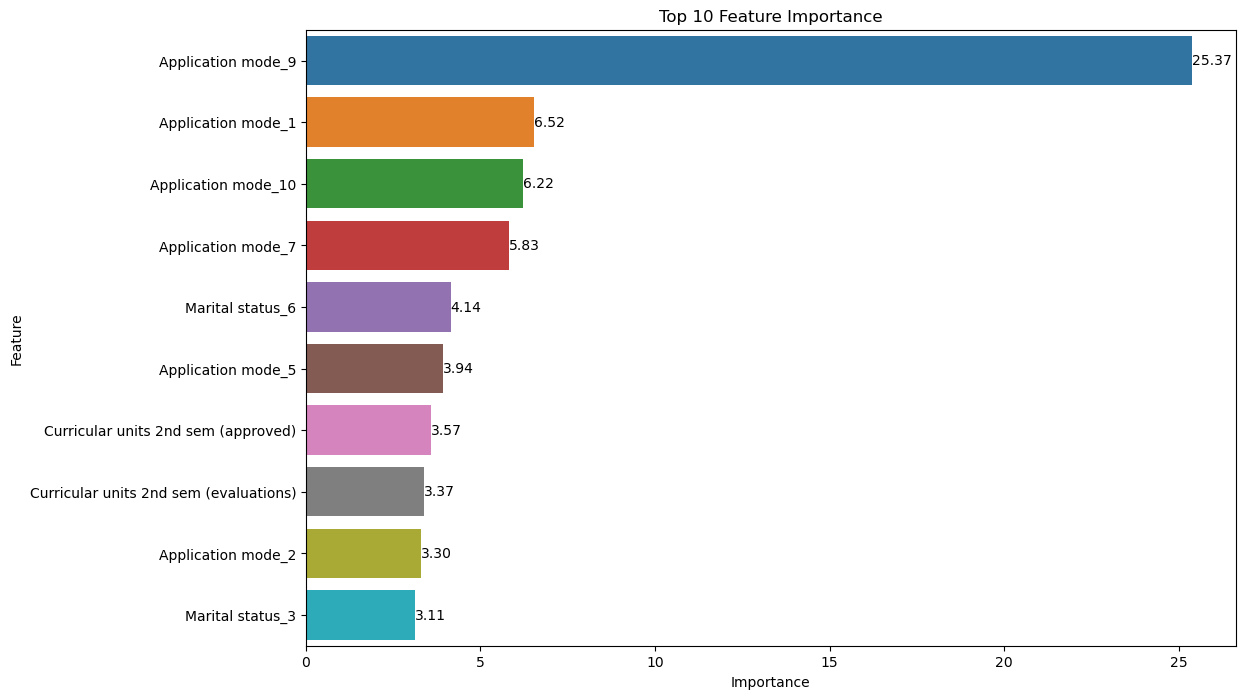

In [17]:
# Display feature importance for the best model
catboost_model_best = best_model.named_steps['algo']
feature_importances = catboost_model_best.get_feature_importance()
feature_names = (best_model.named_steps['prep'].named_transformers_['categoric'].named_steps['onehot'].get_feature_names_out().tolist() + 
                 best_model.named_steps['prep'].named_transformers_['numeric'].feature_names_in_.tolist())

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Filter to get top 10 features
top_10_features = feature_importance_df.head(10)

# Plot feature importance for top 10 features
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Add labels to the bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')

plt.show()

# Apply to New Dataset

In [18]:
df_test = pd.read_csv(r"C:\Users\ACER\Downloads\playground-series-s4e6\test.csv", index_col = 'id')
df_test

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
id,,,,,,,,,,,,,,,,,,,,,
76518,1,1,1,9500,1,1,141.0,1,3,1,...,0,0,8,0,0,0.000000,0,13.9,-0.3,0.79
76519,1,1,1,9238,1,1,128.0,1,1,19,...,0,0,6,6,6,13.500000,0,11.1,0.6,2.02
76520,1,1,1,9238,1,1,118.0,1,1,19,...,0,0,6,11,5,11.000000,0,15.5,2.8,-4.06
76521,1,44,1,9147,1,39,130.0,1,1,19,...,0,3,8,14,5,11.000000,0,8.9,1.4,3.51
76522,1,39,1,9670,1,1,110.0,1,1,37,...,0,0,6,9,4,10.666667,2,7.6,2.6,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127525,1,1,2,171,1,1,128.0,1,38,37,...,0,0,0,0,0,0.000000,0,15.5,2.8,-4.06
127526,2,39,1,9119,1,19,133.1,1,19,37,...,0,0,5,5,0,0.000000,0,9.4,-0.8,-3.12
127527,1,1,1,171,1,1,127.0,1,1,1,...,0,0,0,0,0,0.000000,0,15.5,2.8,-4.06


In [19]:
X_test_new = df_test.copy()

In [20]:
X_test_new_transformed = best_model.named_steps['prep'].transform(X_test_new)

In [21]:
new_predictions = best_model.named_steps['algo'].predict(X_test_new_transformed)

In [22]:
new_predictions = le.inverse_transform(new_predictions)

D:\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
df_test['Target'] = new_predictions
results = df_test[['Target']].reset_index()
print(results)

           id    Target
0       76518   Dropout
1       76519  Graduate
2       76520  Graduate
3       76521  Graduate
4       76522  Enrolled
...       ...       ...
51007  127525   Dropout
51008  127526   Dropout
51009  127527   Dropout
51010  127528   Dropout
51011  127529   Dropout

[51012 rows x 2 columns]


In [20]:
results.to_csv(r"C:\Users\ACER\Downloads\Classification with an Academic Success Dataset (CatBoost Model).csv", index=False)